## １．インポート＆定義

In [1]:
import pandas as pd
import numpy as np
import datetime
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb

# 前処理
def preprocessing(results):
    df = results.copy()

    # 着順に数字以外の文字列が含まれているものを取り除く
    df = df[~(df['着順'].astype(str).str.contains('\D'))]
    df['着順'] = df['着順'].astype(int)

    # 性齢を性と年齢に分ける
    df['性'] = df['性齢'].map(lambda x: str(x)[0])
    df['年齢'] = df['性齢'].map(lambda x: str(x)[1:]).astype(int)

    # 馬体重を体重と体重変化に分ける
    df['体重'] = df['馬体重'].str.split('(', expand=True)[0].astype(int)
    df['体重変化'] = df['馬体重'].str.split('(', expand=True)[1].str[:-1].astype(int)

    # データをint, floatに変換
    df['単勝'] = df['単勝'].astype(float)
    df['course_len'] = df['course_len'].astype(int)
    
    # 不要な列を削除
    df.drop(['タイム', '着差', '調教師', '性齢', '馬体重', '馬名', '騎手'], axis=1, inplace=True)
    
    df['date'] = pd.to_datetime(df['date'], format='%Y年%m月%d日')

    return df

# 時系列に沿ってデータを分割
def split_data(df, test_size=0.3):
    sorted_id_list = df.sort_values('date').index.unique()   
    train_id_list = sorted_id_list[:round(len(sorted_id_list) * (1 - test_size))]
    test_id_list = sorted_id_list[round(len(sorted_id_list) * (1 - test_size)):]
    train = df.loc[train_id_list].drop(['date'], axis=1)
    test = df.loc[test_id_list].drop(['date'], axis=1)
    return train, test

class HorseResults:
    def __init__(self, horse_results):
        self.horse_results = horse_results[['日付', '着順', '賞金']]
        self.preprocessing()
        
    def preprocessing(self):
        df = self.horse_results.copy()
        
        # 着順に数字以外の文字列が含まれているものを取り除く
        df['着順'] = pd.to_numeric(df['着順'], errors='coerce')
        df.dropna(subset=['着順'], inplace=True)
        df['着順'] = df['着順'].astype(int)
        
        df['date'] = pd.to_datetime(df['日付'])
        df.drop(['日付'], axis=1, inplace=True)
        
        # 賞金の欠損値を0で埋める
        df['賞金'].fillna(0, inplace=True)
        
        self.horse_results = df
    
    def average(self, horse_id_list, date, n_samples='all'):
        target_df = self.horse_results.loc[horse_id_list]
        
        # 過去何走分取り出すか指定
        if n_samples == 'all':
            filtered_df = target_df[target_df['date'] < date]
        elif n_samples > 0:
            filtered_df = target_df[target_df['date'] < date].sort_values('date', ascending=False).groupby(level=0).head(n_samples)
        else:
            raise Exception('n_samples must be integer')
            
        average = filtered_df.groupby(level=0)[['着順', '賞金']].mean()
        rename_columns = average.rename(columns={'着順': f'着順_{n_samples}R', '賞金': f'賞金_{n_samples}R'})
        return rename_columns
    
    def merge(self, results, date, n_samples='all'):
        df = results[results['date'] == date]
        horse_id_list = df['horse_id']
        merged_df = df.merge(self.average(horse_id_list, date, n_samples), left_on='horse_id', right_index=True, how='left')
        return merged_df
    
    def merge_all(self, results, n_samples='all'):
        date_list = results['date'].unique()
        merged_df = pd.concat([self.merge(results, date, n_samples) for date in date_list])
        return merged_df
    
class Return:
    def __init__(self, return_tables):
        self.return_tables = return_tables
    
    @property
    def fukusho(self):
        # 複勝の勝ち馬と払い戻しのデータを取り出す
        fukusho = self.return_tables[self.return_tables[0] == '複勝'][[1, 2]]
        
        # 勝ち馬
        wins = fukusho[1].str.split('br', expand=True)[[0, 1, 2]]
        wins.columns = ['win_0', 'win_1', 'win_2']
        
        # 払い戻し
        returns = fukusho[2].str.split('br', expand=True)[[0, 1, 2]]
        returns.columns = ['return_0', 'return_1', 'return_2']
        
        df = pd.concat([wins, returns], axis=1)
        
        # int型に変換できないデータがあるので処理
        for column in df.columns:
            df[column] = df[column].str.replace(',', '')
            
        df = df.fillna(0).astype(int)
        
        return df
    
    @property
    def tansho(self):
        tansho = self.return_tables[self.return_tables[0] == '単勝'][[1, 2]]
        tansho.columns = ['win', 'return']
        
        for column in tansho.columns:
            tansho[column] = pd.to_numeric(tansho[column], errors='coerce')
            
        return tansho
    
class ModelEvaluator:
    def __init__(self, model, return_tables, std=True):
        self.model = model
        self.fukusho = Return(return_tables).fukusho
        self.tansho = Return(return_tables).tansho
        self.std = std
        
    def predict_proba(self, x):
        # 1（3着以内）になる確率を予測
        proba = pd.Series(self.model.predict_proba(x)[:, 1], index=x.index)
        if self.std:
            # 標準化
            standard_scaler = lambda x: (x - x.mean()) / x.std()
            proba = proba.groupby(level=0).transform(standard_scaler)
            # MinMaxスケーリング：データを0から1にする
            proba = (proba - proba.min()) / (proba.max() - proba.min())
        return proba
    
    def predict(self, x, threshold=0.5):
        # thresholdの値によってpredict_probaで出した値を0か1に決定する
        y_pred = self.predict_proba(x)
        return [0 if p < threshold else 1 for p in y_pred]
    
    def score(self, y_true, x):
        # スコアを表示
        return roc_auc_score(y_true, self.predict_proba(x))
    
    def feature_importance(self, x, n_display=20):
        # 変数の重要度を出力
        importances = pd.DataFrame(
            {"features": x.columns, "importance": self.model.feature_importances_}
        )
        return importances.sort_values('importance', ascending=False)[:n_display]
    
    def pred_table(self, x, threshold=0.5, bet_only=True):
        # 予測したレースIDと馬番を出力する
        pred_table = x.copy()[['馬番']]
        pred_table['pred'] = self.predict(x, threshold)
        
        if bet_only:
            return pred_table[pred_table['pred'] == 1]['馬番']
        
        return pred_table
    
    def fukusho_return(self, x, threshold=0.5):
        # 複勝の払い戻しを表示
        pred_table = self.pred_table(x, threshold)
        n_bets = len(pred_table)
        money = -100 * n_bets
        df = self.fukusho.copy()
        df = df.merge(pred_table, left_index=True, right_index=True, how='right')
        for i in range(3):
            money += df[df[f'win_{i}'] == df['馬番']][f'return_{i}'].sum()
        
        return n_bets, int(money)
    
    def tansho_return(self, x, threshold=0.5):
        # 単勝の払い戻しを表示
        pred_table = self.pred_table(x, threshold)
        n_bets = len(pred_table)
        money = -100 * n_bets
        df = self.tansho.copy()
        df = df.merge(pred_table, left_index=True, right_index=True, how='right')
        money += df[df['win'] == df['馬番']]['return'].sum()
        
        return n_bets, int(money)

# 回収率を計算
def gain(return_func, x, n_samples=100, lower=50, min_threshold=0.5):
    gain = {}
    for i in tqdm(range(n_samples)):
        threshold = (i / n_samples) + (min_threshold * (1 - (i / n_samples)))
        n_bets, money = return_func(x, threshold)
        if n_bets > lower:
            gain[n_bets] = (n_bets * 100 + money) / (n_bets * 100)
    return pd.Series(gain)

# カテゴリ変数化
def process_categorical(df, target_columns):
    copy_df = df.copy()
    for column in target_columns:
        copy_df[column] = LabelEncoder().fit_transform(copy_df[column])
    
    # target_columns以外にカテゴリ変数があれば、ダミー変数化する
    copy_df = pd.get_dummies(copy_df)   
    
    for column in target_columns:
        copy_df[column] = copy_df[column].astype('category')
    
    return copy_df

### 1.1　pickleファイル

In [2]:
results = pd.read_pickle('results3.pickle')
horse_results = pd.read_pickle('horse_results.pickle')
return_tables = pd.read_pickle('return_tables.pickle')
peds = pd.read_pickle('peds.pickle')

In [3]:
results_p = preprocessing(results)
results_p.head()

,着順,枠番,馬番,斤量,単勝,人気,horse_id,jockey_id,course_len,weather,race_type,ground_state,date,性,年齢,体重,体重変化
201901010101,1,1,1,54.0,1.4,1.0,2017105318,05339,1800,曇,芝,良,2019-07-27,牡,2,518,-16
201901010101,2,3,3,54.0,3.5,2.0,2017104612,05203,1800,曇,芝,良,2019-07-27,牡,2,496,-8
201901010101,3,4,4,51.0,46.6,6.0,2017103879,01180,1800,曇,芝,良,2019-07-27,牡,2,546,6
201901010101,4,8,9,51.0,56.8,7.0,2017106259,01179,1800,曇,芝,良,2019-07-27,牡,2,458,-8
201901010101,5,5,5,54.0,140.3,9.0,2017104140,01062,1800,曇,芝,良,2019-07-27,牡,2,436,0


In [4]:
hr = HorseResults(horse_results)
results_m = hr.merge_all(results_p, n_samples=5)
results_m.head()

,着順,枠番,馬番,斤量,単勝,人気,horse_id,jockey_id,course_len,weather,race_type,ground_state,date,性,年齢,体重,体重変化,着順_5R,賞金_5R
201901010101,1,1,1,54.0,1.4,1.0,2017105318,05339,1800,曇,芝,良,2019-07-27,牡,2,518,-16,3.0,180.0
201901010101,2,3,3,54.0,3.5,2.0,2017104612,05203,1800,曇,芝,良,2019-07-27,牡,2,496,-8,2.0,280.0
201901010101,3,4,4,51.0,46.6,6.0,2017103879,01180,1800,曇,芝,良,2019-07-27,牡,2,546,6,10.0,0.0
201901010101,4,8,9,51.0,56.8,7.0,2017106259,01179,1800,曇,芝,良,2019-07-27,牡,2,458,-8,4.0,110.0
201901010101,5,5,5,54.0,140.3,9.0,2017104140,01062,1800,曇,芝,良,2019-07-27,牡,2,436,0,9.0,0.0


In [5]:
results_m = hr.merge_all(results_m, n_samples=9)
results_m = hr.merge_all(results_m, n_samples='all')
results_m.head()

,着順,枠番,馬番,斤量,単勝,人気,horse_id,jockey_id,course_len,weather,...,性,年齢,体重,体重変化,着順_5R,賞金_5R,着順_9R,賞金_9R,着順_allR,賞金_allR
201901010101,1,1,1,54.0,1.4,1.0,2017105318,05339,1800,曇,...,牡,2,518,-16,3.0,180.0,3.0,180.0,3.0,180.0
201901010101,2,3,3,54.0,3.5,2.0,2017104612,05203,1800,曇,...,牡,2,496,-8,2.0,280.0,2.0,280.0,2.0,280.0
201901010101,3,4,4,51.0,46.6,6.0,2017103879,01180,1800,曇,...,牡,2,546,6,10.0,0.0,10.0,0.0,10.0,0.0
201901010101,4,8,9,51.0,56.8,7.0,2017106259,01179,1800,曇,...,牡,2,458,-8,4.0,110.0,4.0,110.0,4.0,110.0
201901010101,5,5,5,54.0,140.3,9.0,2017104140,01062,1800,曇,...,牡,2,436,0,9.0,0.0,9.0,0.0,9.0,0.0


In [6]:
results_m = results_m.merge(peds, left_on='horse_id', right_index=True, how='left')
results_m.head()

,着順,枠番,馬番,斤量,単勝,人気,horse_id,jockey_id,course_len,weather,...,peds_52,peds_53,peds_54,peds_55,peds_56,peds_57,peds_58,peds_59,peds_60,peds_61
201901010101,1,1,1,54.0,1.4,1.0,2017105318,05339,1800,曇,...,Busted,Tina,Northern Dancer,Special,Alydar,Crimson Saint,High Top,Sega Ville,Sir Gaylord,Crepellana
201901010101,2,3,3,54.0,3.5,2.0,2017104612,05203,1800,曇,...,In Reality,Millicent,Raise a Native,Gold Digger,Venetian Jester,Friendly Ways,Northern Dancer,Goofed,Hard Tack,Polly Macaw
201901010101,3,4,4,51.0,46.6,6.0,2017103879,01180,1800,曇,...,リマンド,イコマエイカン,In Reality,Foggy Note,Al Nasr,Gonfalon,Bold Reasoning,My Charmer,Graustark,Queen's Paradise
201901010101,4,8,9,51.0,56.8,7.0,2017106259,01179,1800,曇,...,Luciano,Suleika,Nijinsky,Foreseer,Sadler's Wells,Sun Princess,Alydar,ベーシイド,プロント,トサモアー
201901010101,5,5,5,54.0,140.3,9.0,2017104140,01062,1800,曇,...,Home Guard,Gradiva,Balidar,Brig O'Doon,Sharpen Up,L'Anguissola,Surumu,Aggravate,Prince Ippi,Tania


In [7]:
categorical_columns = ['horse_id'] + [f'peds_{i}' for i in range(62)]
results_d = process_categorical(results_m, categorical_columns)

In [8]:
results_d['rank'] = results_d['着順'].map(lambda x: 1 if x < 4 else 0)
results_r = results_d.drop(['着順', '単勝', '人気'], axis=1)

In [9]:
train, test = split_data(results_r)
X_train = train.drop(['rank'], axis=1)
y_train = train['rank']
X_test = test.drop(['rank'], axis=1)
y_test = test['rank']

In [10]:
params = {
    'num_leaves': 4,
    'n_estimators': 80,
    'class_weight': 'balanced',
    'random_state': 100
}

lgb_clf = lgb.LGBMClassifier(**params)
lgb_clf.fit(X_train.values, y_train.values)

LGBMClassifier(class_weight='balanced', n_estimators=80, num_leaves=4,
               random_state=100)

In [11]:
me = ModelEvaluator(lgb_clf, return_tables, std=False)
me.feature_importance(X_test, 10)

,features,importance
8,着順_5R,31
3,horse_id,23
9,賞金_5R,21
12,着順_allR,18
6,体重,13
228,jockey_id_05339,12
136,jockey_id_01088,10
2,斤量,9
10,着順_9R,8
232,jockey_id_05386,7


In [12]:
baseline = gain(me.tansho_return, X_test)

100%|██████████| 100/100 [00:29<00:00,  3.41it/s]


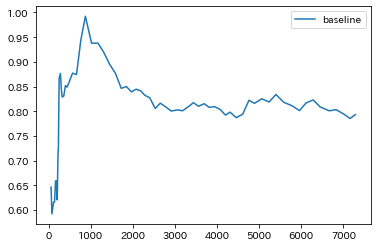

In [13]:
baseline.rename('baseline').plot(legend=True)

In [14]:
me.predict_proba(X_test)

201909040104    0.625173
201909040104    0.487987
201909040104    0.427746
201909040104    0.604138
201909040104    0.418844
                  ...   
201909050902    0.280523
201909050902    0.266709
201909050902    0.230784
201909050902    0.529579
201909050902    0.117388
Length: 13997, dtype: float64

In [15]:
proba_table = X_test[['horse_id']].copy()
proba_table['proba'] = me.predict_proba(X_test)
proba_table

,horse_id,proba
201909040104,10663,0.625173
201909040104,8494,0.487987
201909040104,8347,0.427746
201909040104,11065,0.604138
201909040104,9465,0.418844
...,...,...
201909050902,10254,0.280523
201909050902,8485,0.266709
201909050902,8919,0.230784
201909050902,10352,0.529579


In [16]:
proba_table['R'] = proba_table.index.map(lambda x: str(x)[-2:])
proba_table

,horse_id,proba,R
201909040104,10663,0.625173,04
201909040104,8494,0.487987,04
201909040104,8347,0.427746,04
201909040104,11065,0.604138,04
201909040104,9465,0.418844,04
...,...,...,...
201909050902,10254,0.280523,02
201909050902,8485,0.266709,02
201909050902,8919,0.230784,02
201909050902,10352,0.529579,02


In [17]:
proba_table.groupby('R')['proba'].mean()

R
01    0.390112
02    0.447505
03    0.468792
04    0.466651
05    0.497443
06    0.488063
07    0.508928
08    0.522037
09    0.559513
10    0.537799
11    0.544138
12    0.502007
Name: proba, dtype: float64

## 2．標準化

In [18]:
X = proba_table.loc['201906040307']['proba']

平均
$$ μ ≡ E(X) = \frac{1}{13}(X_1 + X_2 + \cdots + X_{13}) $$

In [19]:
X.mean()

0.5518352282520959

分散
$$ V(X) = \frac{1}{13}\left((X_1-E(X))^2 + (X_2-E(X))^2 + \cdots + (X_{13}-E(X))^2 \right) $$

In [20]:
X.var()

0.01719361016423315

標準偏差
$$ σ ≡ \sqrt{V(X)} $$

In [21]:
X.std()

0.13112440720259957

標準化
$$ Z_i = \frac{X_i-μ}{σ} $$

In [22]:
X_std = (X - X.mean()) / X.std()
X_std

201906040307    1.737462
201906040307    0.196809
201906040307    0.446554
201906040307   -0.075037
201906040307    0.391831
201906040307    1.309906
201906040307   -1.602881
201906040307   -0.481510
201906040307   -0.089848
201906040307   -0.089192
201906040307    0.744342
201906040307   -0.796583
201906040307   -1.691853
Name: proba, dtype: float64

In [23]:
X_std.sum()

2.220446049250313e-16

In [24]:
X_std.var()

1.0000000000000002

### 2.1　実装

In [25]:
me = ModelEvaluator(lgb_clf, return_tables, std=True)

In [26]:
gain_std = gain(me.tansho_return, X_test)

100%|██████████| 100/100 [01:40<00:00,  1.01s/it]


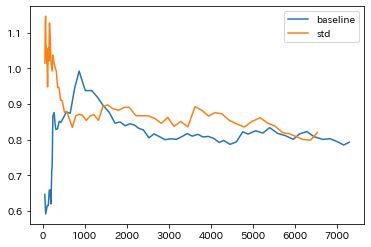

In [27]:
baseline.rename('baseline').plot(legend=True)
gain_std.rename('std').plot(legend=True)

In [28]:
gain_std.max()

1.1464788732394366

In [29]:
gain_std[50:]

268    1.016418
245    1.037551
226    0.992478
197    1.019797
180    1.089444
163    1.127607
148    1.020946
134    1.056716
118    0.948305
109    1.010092
101    1.012871
93     1.032258
85     1.061176
78     1.070513
71     1.146479
63     1.119048
57     1.028070
53     1.015094
dtype: float64

In [30]:
X_test.index.nunique()

1036

In [31]:
np.sum(me.predict(X_test, threshold=0.82))

71

In [32]:
me.pred_table(X_test,  threshold=0.82)

201909040208     7
201909040203     8
201909040201     6
201906040305     4
201906040405    13
                ..
201909050705    16
201906050802    14
201906050905     9
201909050905    10
201909050904    13
Name: 馬番, Length: 71, dtype: int64

In [33]:
_, sample = split_data(results_m)
bets = sample[['着順', '人気', '単勝', '馬番']].merge(me.pred_table(X_test, threshold=0.82), left_index=True, right_index=True, how='right')
bets

,着順,人気,単勝,馬番_x,馬番_y
201905040104,1,7.0,21.3,5,8
201905040104,2,3.0,7.0,16,8
201905040104,3,6.0,19.1,11,8
201905040104,4,2.0,4.3,6,8
201905040104,5,5.0,12.8,4,8
...,...,...,...,...,...
201909050905,6,6.0,31.6,3,10
201909050905,7,9.0,89.8,6,10
201909050905,8,7.0,74.2,7,10
201909050905,9,10.0,92.3,4,10


In [34]:
bets[bets['馬番_x'] == bets['馬番_y']]['人気'].value_counts()

1.0    34
2.0    17
3.0     7
4.0     6
7.0     3
5.0     2
6.0     2
Name: 人気, dtype: int64

In [35]:
bets[(bets['馬番_x'] == bets['馬番_y']) & (bets['着順'] == 1)]['人気'].value_counts()

1.0    15
2.0     6
7.0     1
4.0     1
3.0     1
Name: 人気, dtype: int64

In [36]:
len(bets[(bets['馬番_x'] == bets['馬番_y']) & (bets['着順'] == 1)]) / 71 * 100

33.80281690140845

In [37]:
len(sample[sample['人気'] == 1])

1034

In [38]:
len(sample[(sample['人気'] == 1) & (sample['着順'] == 1)])

342

In [39]:
rt = Return(return_tables)
rt.tansho

,win,return
201906040103,6.0,750.0
201906040102,5.0,1240.0
201906040104,1.0,160.0
201906040106,8.0,420.0
201906040105,4.0,200.0
...,...,...
201906050904,16.0,550.0
201906050909,2.0,2400.0
201906050908,1.0,910.0
201906050910,14.0,1940.0


In [40]:
bets = rt.tansho.merge(me.pred_table(X_test, threshold=0.82), left_index=True, right_index=True, how='right')
bets

,win,return,馬番
201909040208,7.0,160.0,7
201909040203,8.0,310.0,8
201909040201,9.0,2810.0,6
201906040305,4.0,380.0,4
201906040405,8.0,220.0,13
...,...,...,...
201909050705,2.0,470.0,16
201906050802,13.0,620.0,14
201906050905,9.0,140.0,9
201909050905,10.0,220.0,10


In [41]:
wins = bets[bets['win'] == bets['馬番']]
wins

,win,return,馬番
201909040208,7.0,160.0,7
201909040203,8.0,310.0,8
201906040305,4.0,380.0,4
201906040505,12.0,180.0,12
201906040603,10.0,250.0,10
201909040701,1.0,710.0,1
201909040710,4.0,250.0,4
201906040904,16.0,200.0,16
201906040905,10.0,130.0,10
201908040505,13.0,140.0,13


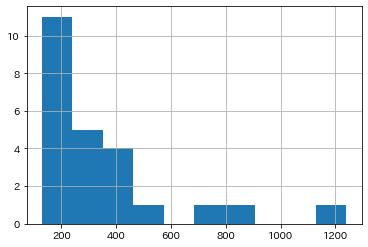

In [42]:
wins['return'].hist()

In [43]:
wins['return'].sum() - 71 * 100

1040.0